In [ ]:
!gdown '1pmDoFqoraypdojpWoEHpZt-9NJjjDKg3' -O bone_marrow_cell_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1pmDoFqoraypdojpWoEHpZt-9NJjjDKg3
From (redirected): https://drive.google.com/uc?id=1pmDoFqoraypdojpWoEHpZt-9NJjjDKg3&confirm=t&uuid=455eeadb-32a9-4557-9b20-7e962c8e193e
To: /content/bone_marrow_cell_dataset.zip
100% 6.93G/6.93G [01:22<00:00, 84.5MB/s]


In [ ]:
!unzip bone_marrow_cell_dataset.zip -d bone_marrow_cell_dataset &> /dev/null

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# @title Defining Segmentation
def otsu_threshold(image):
    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return otsu_thresh

def refine_segmentation(thresholded_image):
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing

def apply_watershed(original_image, binary_image):
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(original_image, markers)
    original_image[markers == -1] = [0, 0, 255]
    return markers

def extract_individual_nuclei(markers, original_image):
    unique_markers = np.unique(markers)
    nuclei_images = []
    for marker in unique_markers:
        if marker <= 1:
            continue
        mask = np.zeros_like(markers, dtype=np.uint8)
        mask[markers == marker] = 255
        nucleus_image = cv2.bitwise_and(original_image, original_image, mask=mask)
        resized_nucleus_image = cv2.resize(nucleus_image, (64, 64))
        nuclei_images.append(resized_nucleus_image)
    return nuclei_images


In [ ]:
# @title Creating DF
image_data = 'bone_marrow_cell_dataset'

files = glob.glob(os.path.join(image_data, '**', '*.jpg'), recursive=True)
classes = [os.path.normpath(file).split(os.sep)[1] for file in files]

df = pd.DataFrame({"filename": files, "label": classes})
print(f"Number of images: {len(df)}")


Number of images: 171374


In [ ]:
# @title Segmenting Images
#segmented_dir = "segmented_nuclei"
#os.makedirs(segmented_dir, exist_ok=True)
#segmented_filepaths = []
#segmented_labels = []

#for idx, row in df.iterrows():
#    original_image = cv2.imread(row['filename'])
#    if original_image is not None:
#        grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
#        otsu_image = otsu_threshold(grayscale_image)
#        refined_image = refine_segmentation(otsu_image)
#        markers = apply_watershed(original_image, refined_image)
#        nuclei_images = extract_individual_nuclei(markers, original_image)

#        for j, nucleus_image in enumerate(nuclei_images):
#            filename = f"{os.path.splitext(os.path.basename(row['filename']))[0]}_seg_{j}.jpg"
#            filepath = os.path.join(segmented_dir, filename)
#            cv2.imwrite(filepath, nucleus_image)
#            segmented_filepaths.append(filepath)
#            segmented_labels.append(row['label'])

#segmented_df = pd.DataFrame({"filename": segmented_filepaths, "label": segmented_labels})


In [ ]:
# @title Code for Exporting Zip
#from google.colab import drive
#drive.mount('/content/drive')

#!zip -r /content/segmented_nuclei.zip /content/segmented_nuclei > /dev/null 2>&1

#!mv /content/segmented_nuclei.zip /content/drive/MyDrive/

#import shutil
#shutil.rmtree('segmented_nuclei', ignore_errors=True)

Mounted at /content/drive


In [ ]:
!gdown '1ktGD3jORvnpnEu1mOAwTy9NL54VoGKA7' -O segmented_nuclei.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ktGD3jORvnpnEu1mOAwTy9NL54VoGKA7
From (redirected): https://drive.google.com/uc?id=1ktGD3jORvnpnEu1mOAwTy9NL54VoGKA7&confirm=t&uuid=b0d880e1-ffda-4a78-a751-48f97db2726f
To: /content/segmented_nuclei.zip
100% 441M/441M [00:04<00:00, 100MB/s]


In [ ]:
!unzip segmented_nuclei.zip -d segmented_nuclei > /dev/null 2> /dev/null

In [ ]:
import os
import pandas as pd

segmented_dir = "segmented_nuclei/content/segmented_nuclei"
segmented_filepaths = []
segmented_labels = []

# Recursively find all .jpg files in the segmented directory
for root, _, files in os.walk(segmented_dir):
    for filename in files:
        if filename.endswith(".jpg"):
            filepath = os.path.join(root, filename)
            label = filename.split("_")[0]  # Extract the label from the filename
            segmented_filepaths.append(filepath)
            segmented_labels.append(label)

# Recreate the DataFrame with segmented file paths and labels
segmented_df = pd.DataFrame({"filename": segmented_filepaths, "label": segmented_labels})

In [ ]:
segmented_df

,filename,label
0,segmented_nuclei/content/segmented_nuclei/EOS_...,EOS
1,segmented_nuclei/content/segmented_nuclei/NGB_...,NGB
2,segmented_nuclei/content/segmented_nuclei/NGS_...,NGS
3,segmented_nuclei/content/segmented_nuclei/NGS_...,NGS
4,segmented_nuclei/content/segmented_nuclei/EBO_...,EBO
...,...,...
331954,segmented_nuclei/content/segmented_nuclei/MON_...,MON
331955,segmented_nuclei/content/segmented_nuclei/LYT_...,LYT
331956,segmented_nuclei/content/segmented_nuclei/NIF_...,NIF
331957,segmented_nuclei/content/segmented_nuclei/NGS_...,NGS


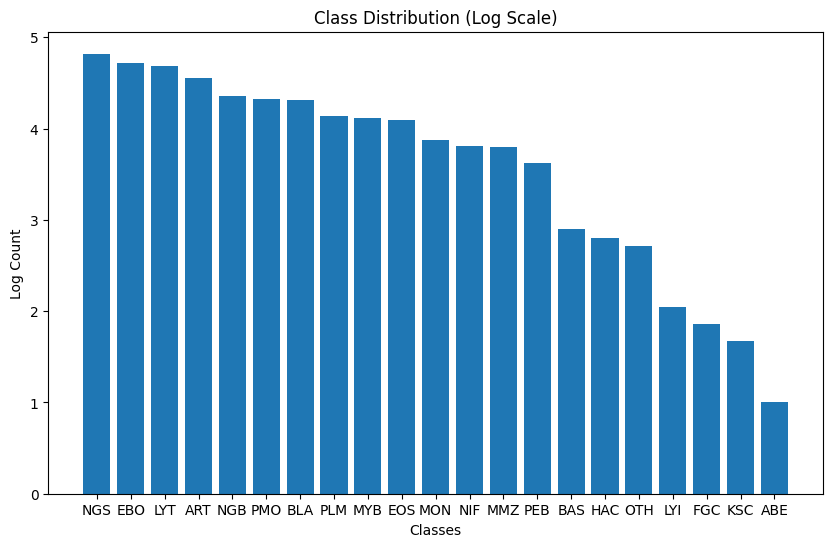

In [ ]:
counts = segmented_df['label'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(counts.index, np.log10(counts.values))
plt.xlabel('Classes')
plt.ylabel('Log Count')
plt.title('Class Distribution (Log Scale)')
plt.show()

In [ ]:
exclude_list = ["ART", "NIF"]
def exclude_label(label):
  if label in exclude_list:
    return False
  return True
reduced_df = segmented_df[segmented_df['label'].apply(exclude_label)]

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(reduced_df, test_size=0.2, random_state=42, stratify=reduced_df["label"])

In [ ]:
image_size = (64, 64)

train_datagen = ImageDataGenerator(
    #rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    #rescale=1.0/255
    )

train = train_datagen.flow_from_dataframe(
    data_train,
    x_col="filename",
    y_col="label",
    shuffle = False,
    target_size=image_size,
    batch_size=256,
    class_mode="categorical"
)

test = test_datagen.flow_from_dataframe(
    data_test,
    x_col="filename",
    y_col="label",
    shuffle = False,
    target_size=image_size,
    batch_size=256,
    class_mode="categorical"
)


Found 232177 validated image filenames belonging to 19 classes.
Found 58045 validated image filenames belonging to 19 classes.


In [ ]:
from tensorflow.keras.applications import VGG19

vgg19_model = VGG19(include_top=False, input_shape=(image_size[0], image_size[1], 3))

num_freeze = int(len(vgg19_model.layers) * 0.2)
for n in range(num_freeze):
    vgg19_model.layers[n].trainable = False

model1 = tf.keras.models.Sequential([
    vgg19_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(data_train['label'].unique()), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [ ]:
history = model1.fit(
    train,
    epochs=1,
    validation_data=test,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

907/907 ━━━━━━━━━━━━━━━━━━━━ 569s 615ms/step - accuracy: 0.2918 - loss: 2.4112 - val_accuracy: 0.4012 - val_loss: 1.7986 - learning_rate: 1.0000e-04


In [ ]:
predictions = model1.predict(test)

  2/227 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
accuracy_score(test.classes , y_pred)

0.4012231889051598

In [ ]:
f1_score(test.classes , y_pred, average='weighted')

0.33081011556569534

In [ ]:
model1.evaluate(test)

227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.4012 - loss: 1.7995


[1.7986233234405518, 0.40122318267822266]

In [ ]:
test.class_indices

{'ABE': 0,
 'BAS': 1,
 'BLA': 2,
 'EBO': 3,
 'EOS': 4,
 'FGC': 5,
 'HAC': 6,
 'KSC': 7,
 'LYI': 8,
 'LYT': 9,
 'MMZ': 10,
 'MON': 11,
 'MYB': 12,
 'NGB': 13,
 'NGS': 14,
 'OTH': 15,
 'PEB': 16,
 'PLM': 17,
 'PMO': 18}

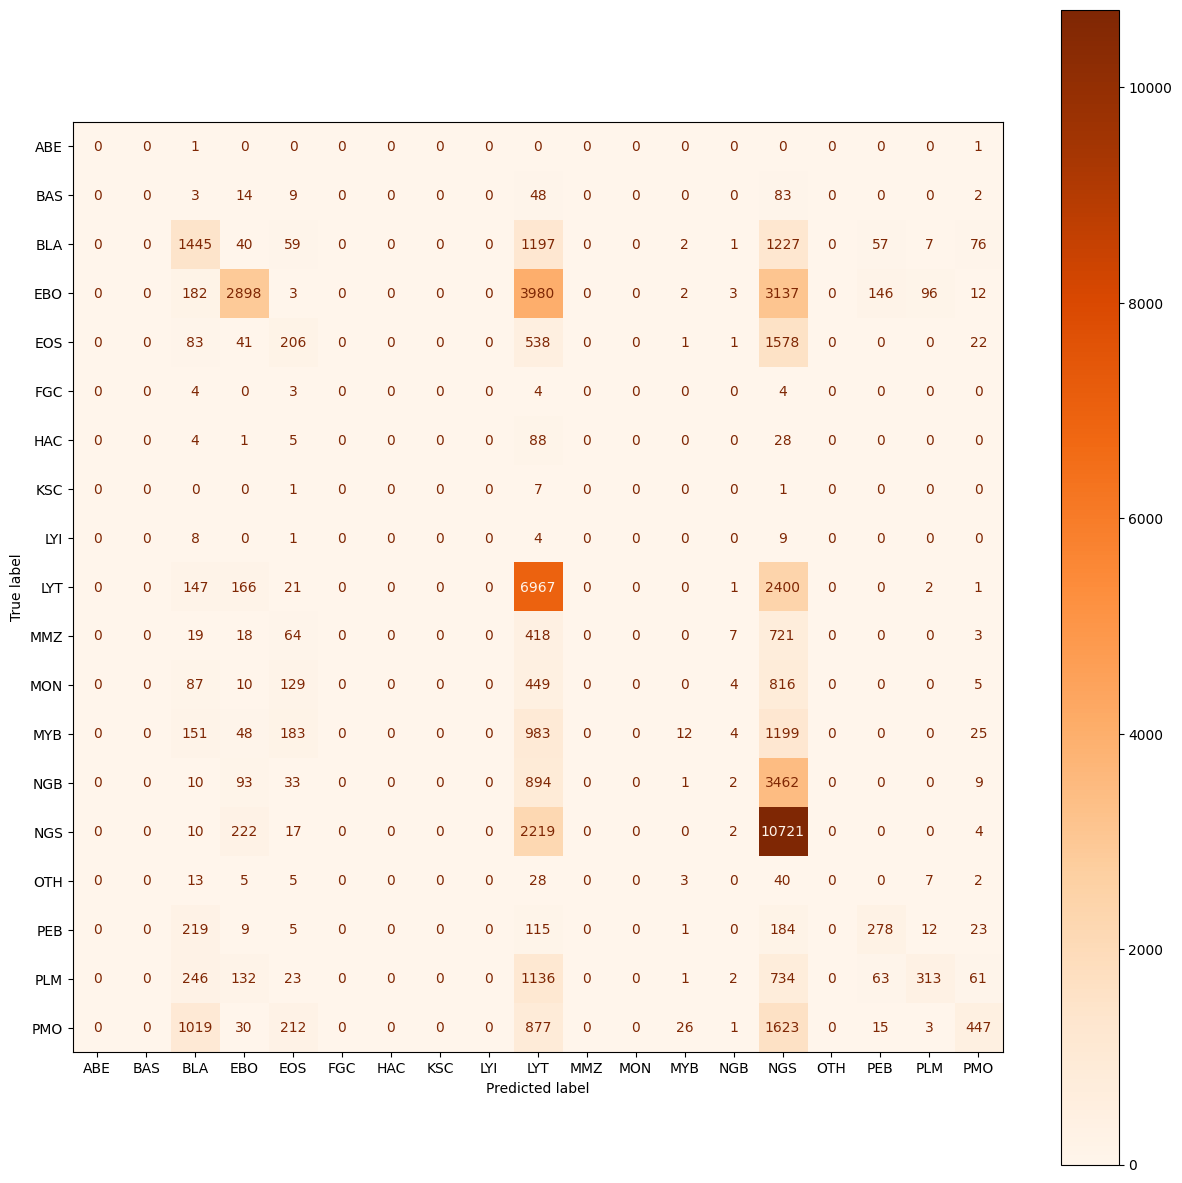

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='Oranges');